In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from typing import Tuple, List

print(os.getcwd())

i:\我的雲端硬碟\Bio_Lab\碩論\code\benchmark\notebook


In [2]:
import logomaker
# create Logo object
def plot_pwm(df: pd.DataFrame, ax: plt.Axes, xlabel: str, ylabel: str, xtick_scale: int, mark_range: Tuple[Tuple[int]]=None) -> plt.Axes:

    crp_logo = logomaker.Logo(df=df,
                                shade_below=.5,
                                fade_below=.5,
                                ax=ax
                                # figsize=(10, 3)
                                )

    # style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.style_xticks(fmt='%d', anchor=0)

    if mark_range != None:
        for range_ in mark_range:
            crp_logo.highlight_position_range(range_[0], range_[1], color='moccasin')
            # mistyrose(淺紅)、wheat(淺橘)、thistle(淺紫)

    # style using Axes methods
    crp_logo.ax.set_xlabel(xlabel, labelpad=10)
    crp_logo.ax.set_ylabel(ylabel, labelpad=10)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)

    # 設定顯示刻度的密度，這邊使用共 20 個刻度
    vis_tick = np.arange(0, df.shape[0], step=round(df.shape[0]/20))
    crp_logo.ax.set_xticks(vis_tick, vis_tick*xtick_scale)

    return crp_logo


In [4]:
tar_files = {
    'Normal': '../output/XAI/MCIENet-helas3.ctcf-1kb/attribution.h5',
    'Left-shift-200': '../output/XAI/MCIENet-helas3.ctcf-1kb_left-shift-200/attribution.h5',
    'Left-shift-500': '../output/XAI/MCIENet-helas3.ctcf-1kb_left-shift-500/attribution.h5',
    'Right-shift-200': '../output/XAI/MCIENet-helas3.ctcf-1kb_right-shift-200/attribution.h5',
    'Right-shift-500': '../output/XAI/MCIENet-helas3.ctcf-1kb_right-shift-500/attribution.h5'
}
output_folder = '../output/XAI-plot/'

os.makedirs(output_folder, exist_ok=True)

tar_phase = 'test'

### Attribution of positive and negative samples

In [5]:
def plot_matrix(ax: plt.Axes, mat: np.array, bin_s: int=50, roll_step: int=50,
                mark_range: List[List[int]] = None, 
                xlabel: str=f'Gene Loci', ylabel: str='Deeplift',
                labels: List[str]=['A', 'G', 'C', 'T']
                ) -> plt.Axes:
    df_attr = pd.DataFrame(mat, index=labels)
    df_attr_roll = df_attr.T.rolling(window=bin_s, step=roll_step).sum().dropna() / bin_s
    df_attr_roll.reset_index(drop=True, inplace=True)

    xlabel = xlabel + f'({bin_s}bp)' if xlabel != None else ''

    ax = plot_pwm(df_attr_roll, ax=ax, xlabel=xlabel, ylabel=ylabel, xtick_scale=bin_s,
                mark_range=mark_range)

    return ax

In [6]:
def scale_and_normalize_batch(tensor):
  """
  批次處理矩陣，對每個矩陣進行縮放和歸一化。

  Args:
    tensor: 形狀為 (batch_size, rows, cols) 的三維張量。

  Returns:
    處理後的張量。
  """

  # 計算每個矩陣的絕對值之和
  total_abs_sums = np.sum(np.abs(tensor), axis=(1, 2))

  # 避免除以零
  total_abs_sums[total_abs_sums == 0] = 1e-12

  # 計算縮放因子
  scale_factors = 1 / total_abs_sums

  # 擴展縮放因子維度，以便與原張量進行廣播運算
  scale_factors = scale_factors[:, np.newaxis, np.newaxis]

  # 縮放並歸一化
  scaled_tensor = tensor * scale_factors

  return scaled_tensor

In [7]:
tar_files

{'Normal': '../output/XAI/MCIENet-helas3.ctcf-1kb/attribution.h5',
 'Left-shift-200': '../output/XAI/MCIENet-helas3.ctcf-1kb_left-shift-200/attribution.h5',
 'Left-shift-500': '../output/XAI/MCIENet-helas3.ctcf-1kb_left-shift-500/attribution.h5',
 'Right-shift-200': '../output/XAI/MCIENet-helas3.ctcf-1kb_right-shift-200/attribution.h5',
 'Right-shift-500': '../output/XAI/MCIENet-helas3.ctcf-1kb_right-shift-500/attribution.h5'}

Normal
Left-shift-200
Left-shift-500
Right-shift-200
Right-shift-500


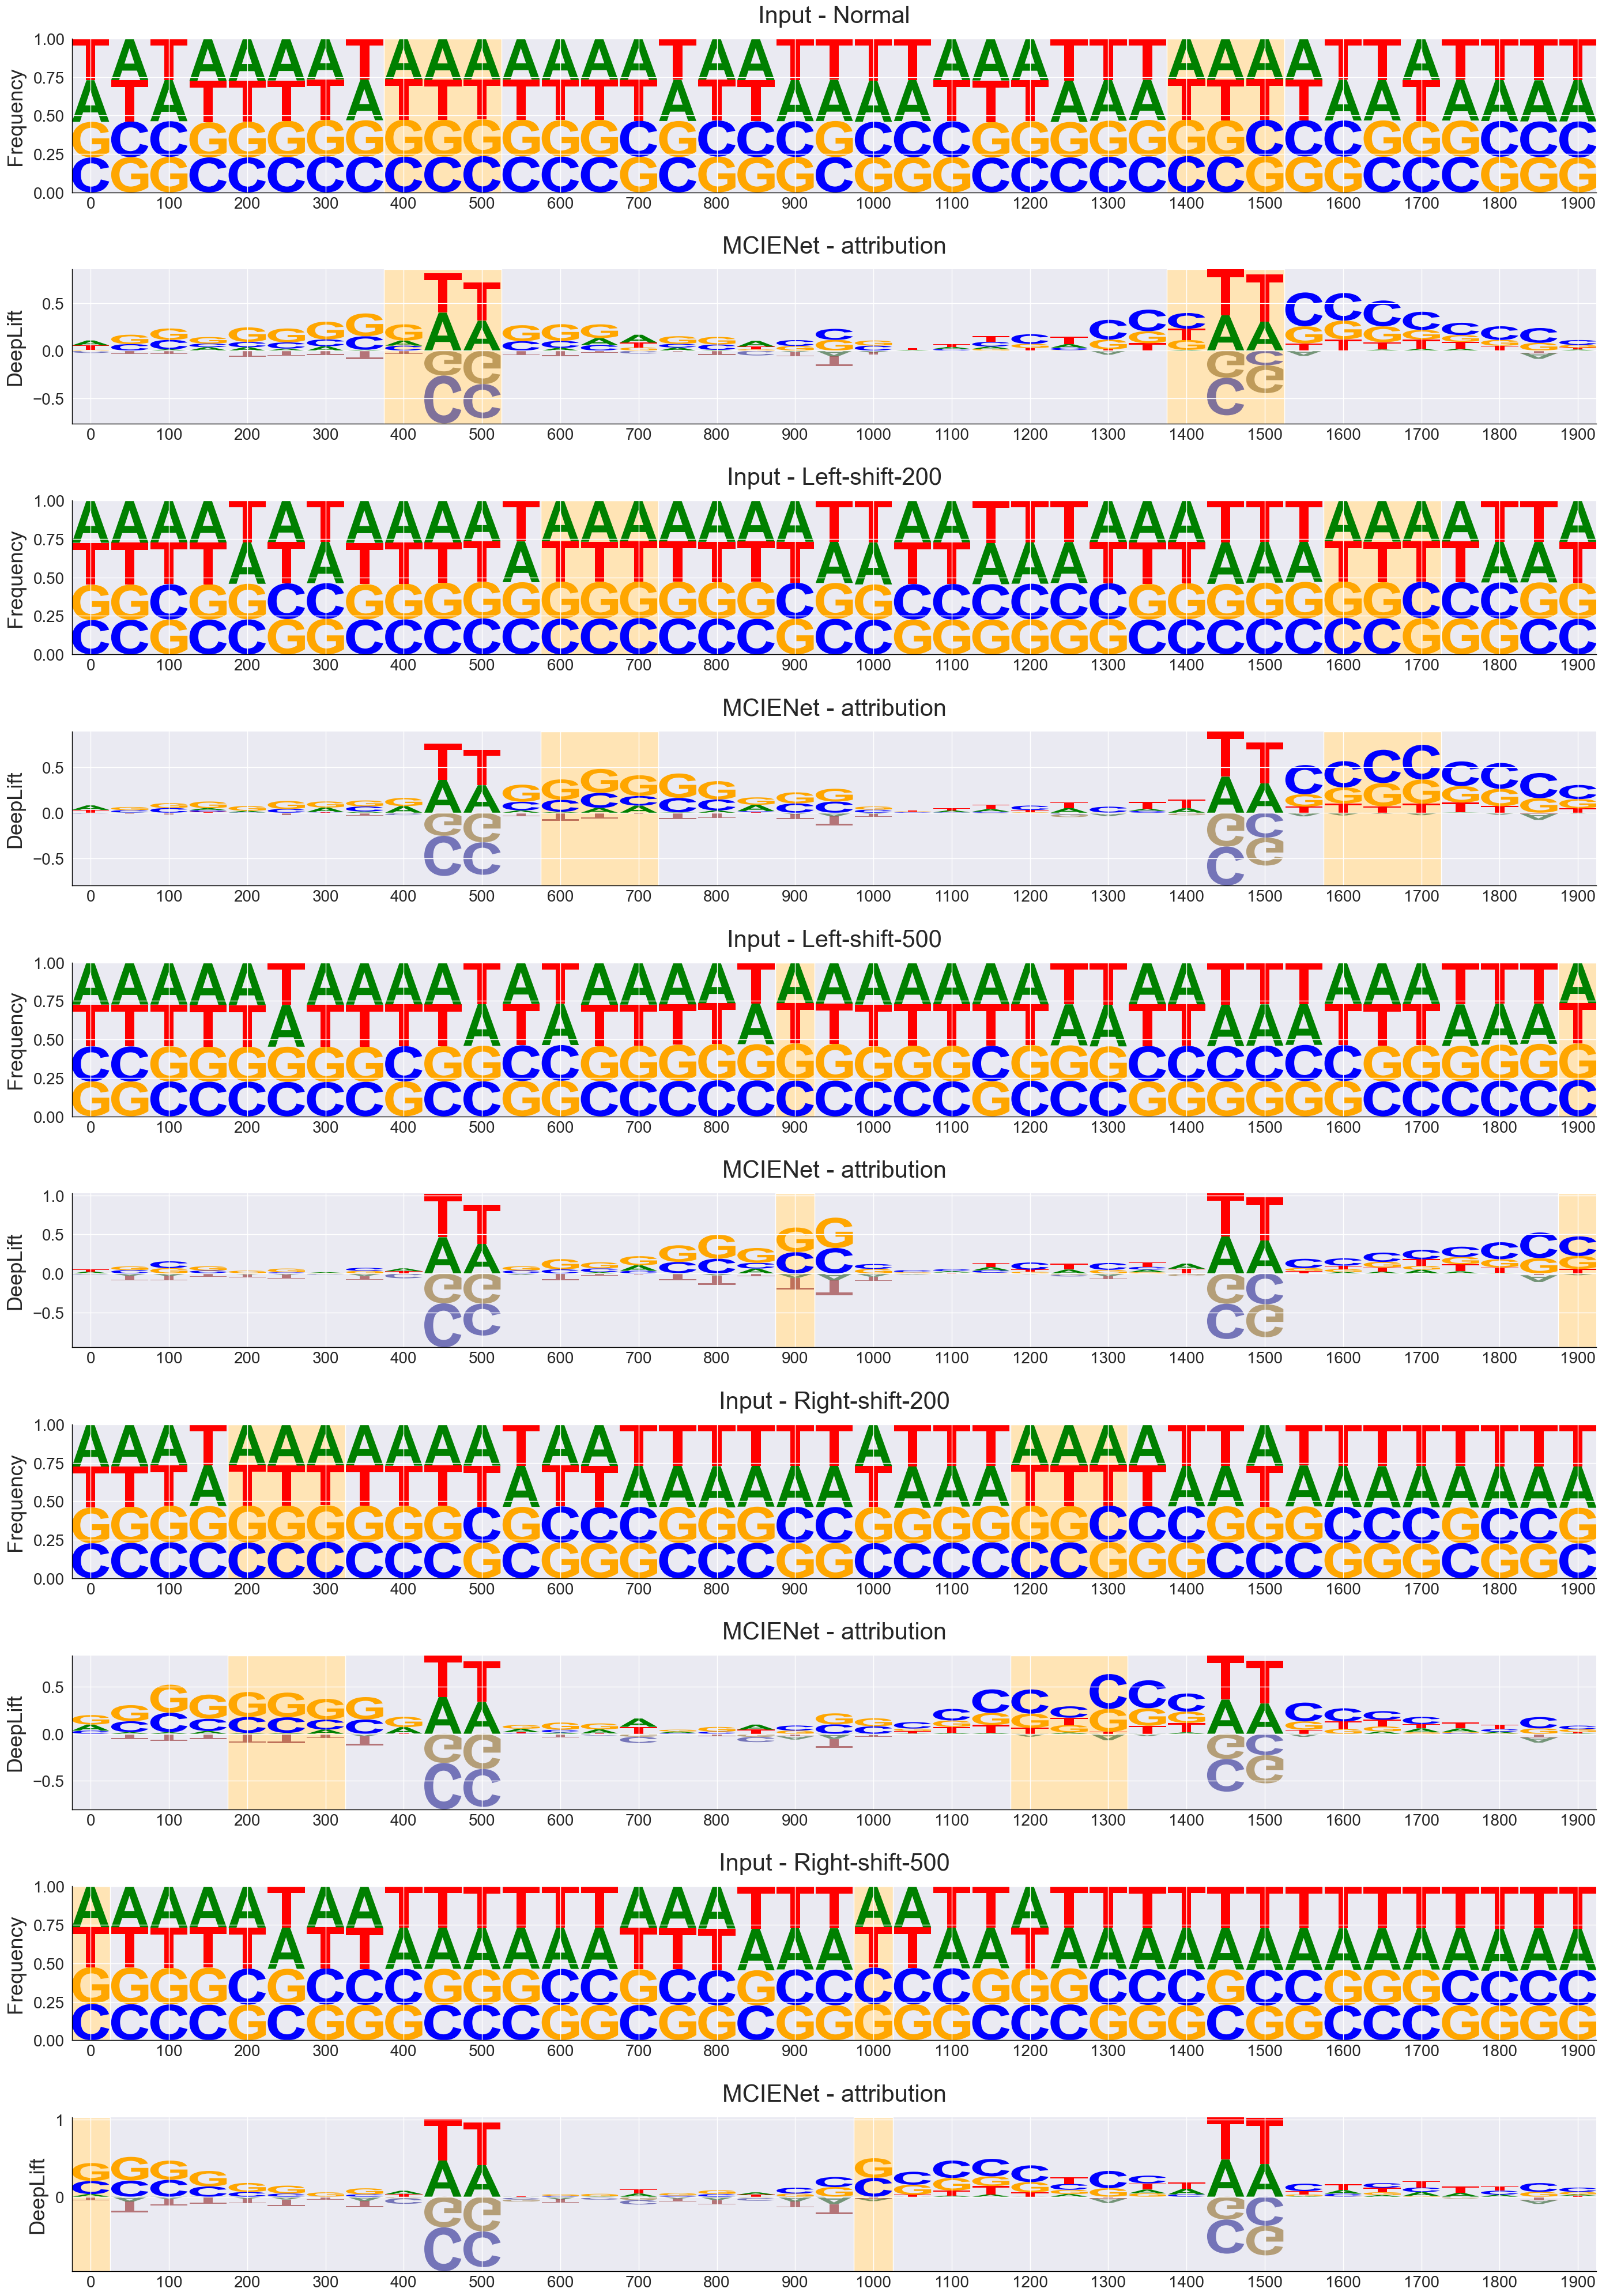

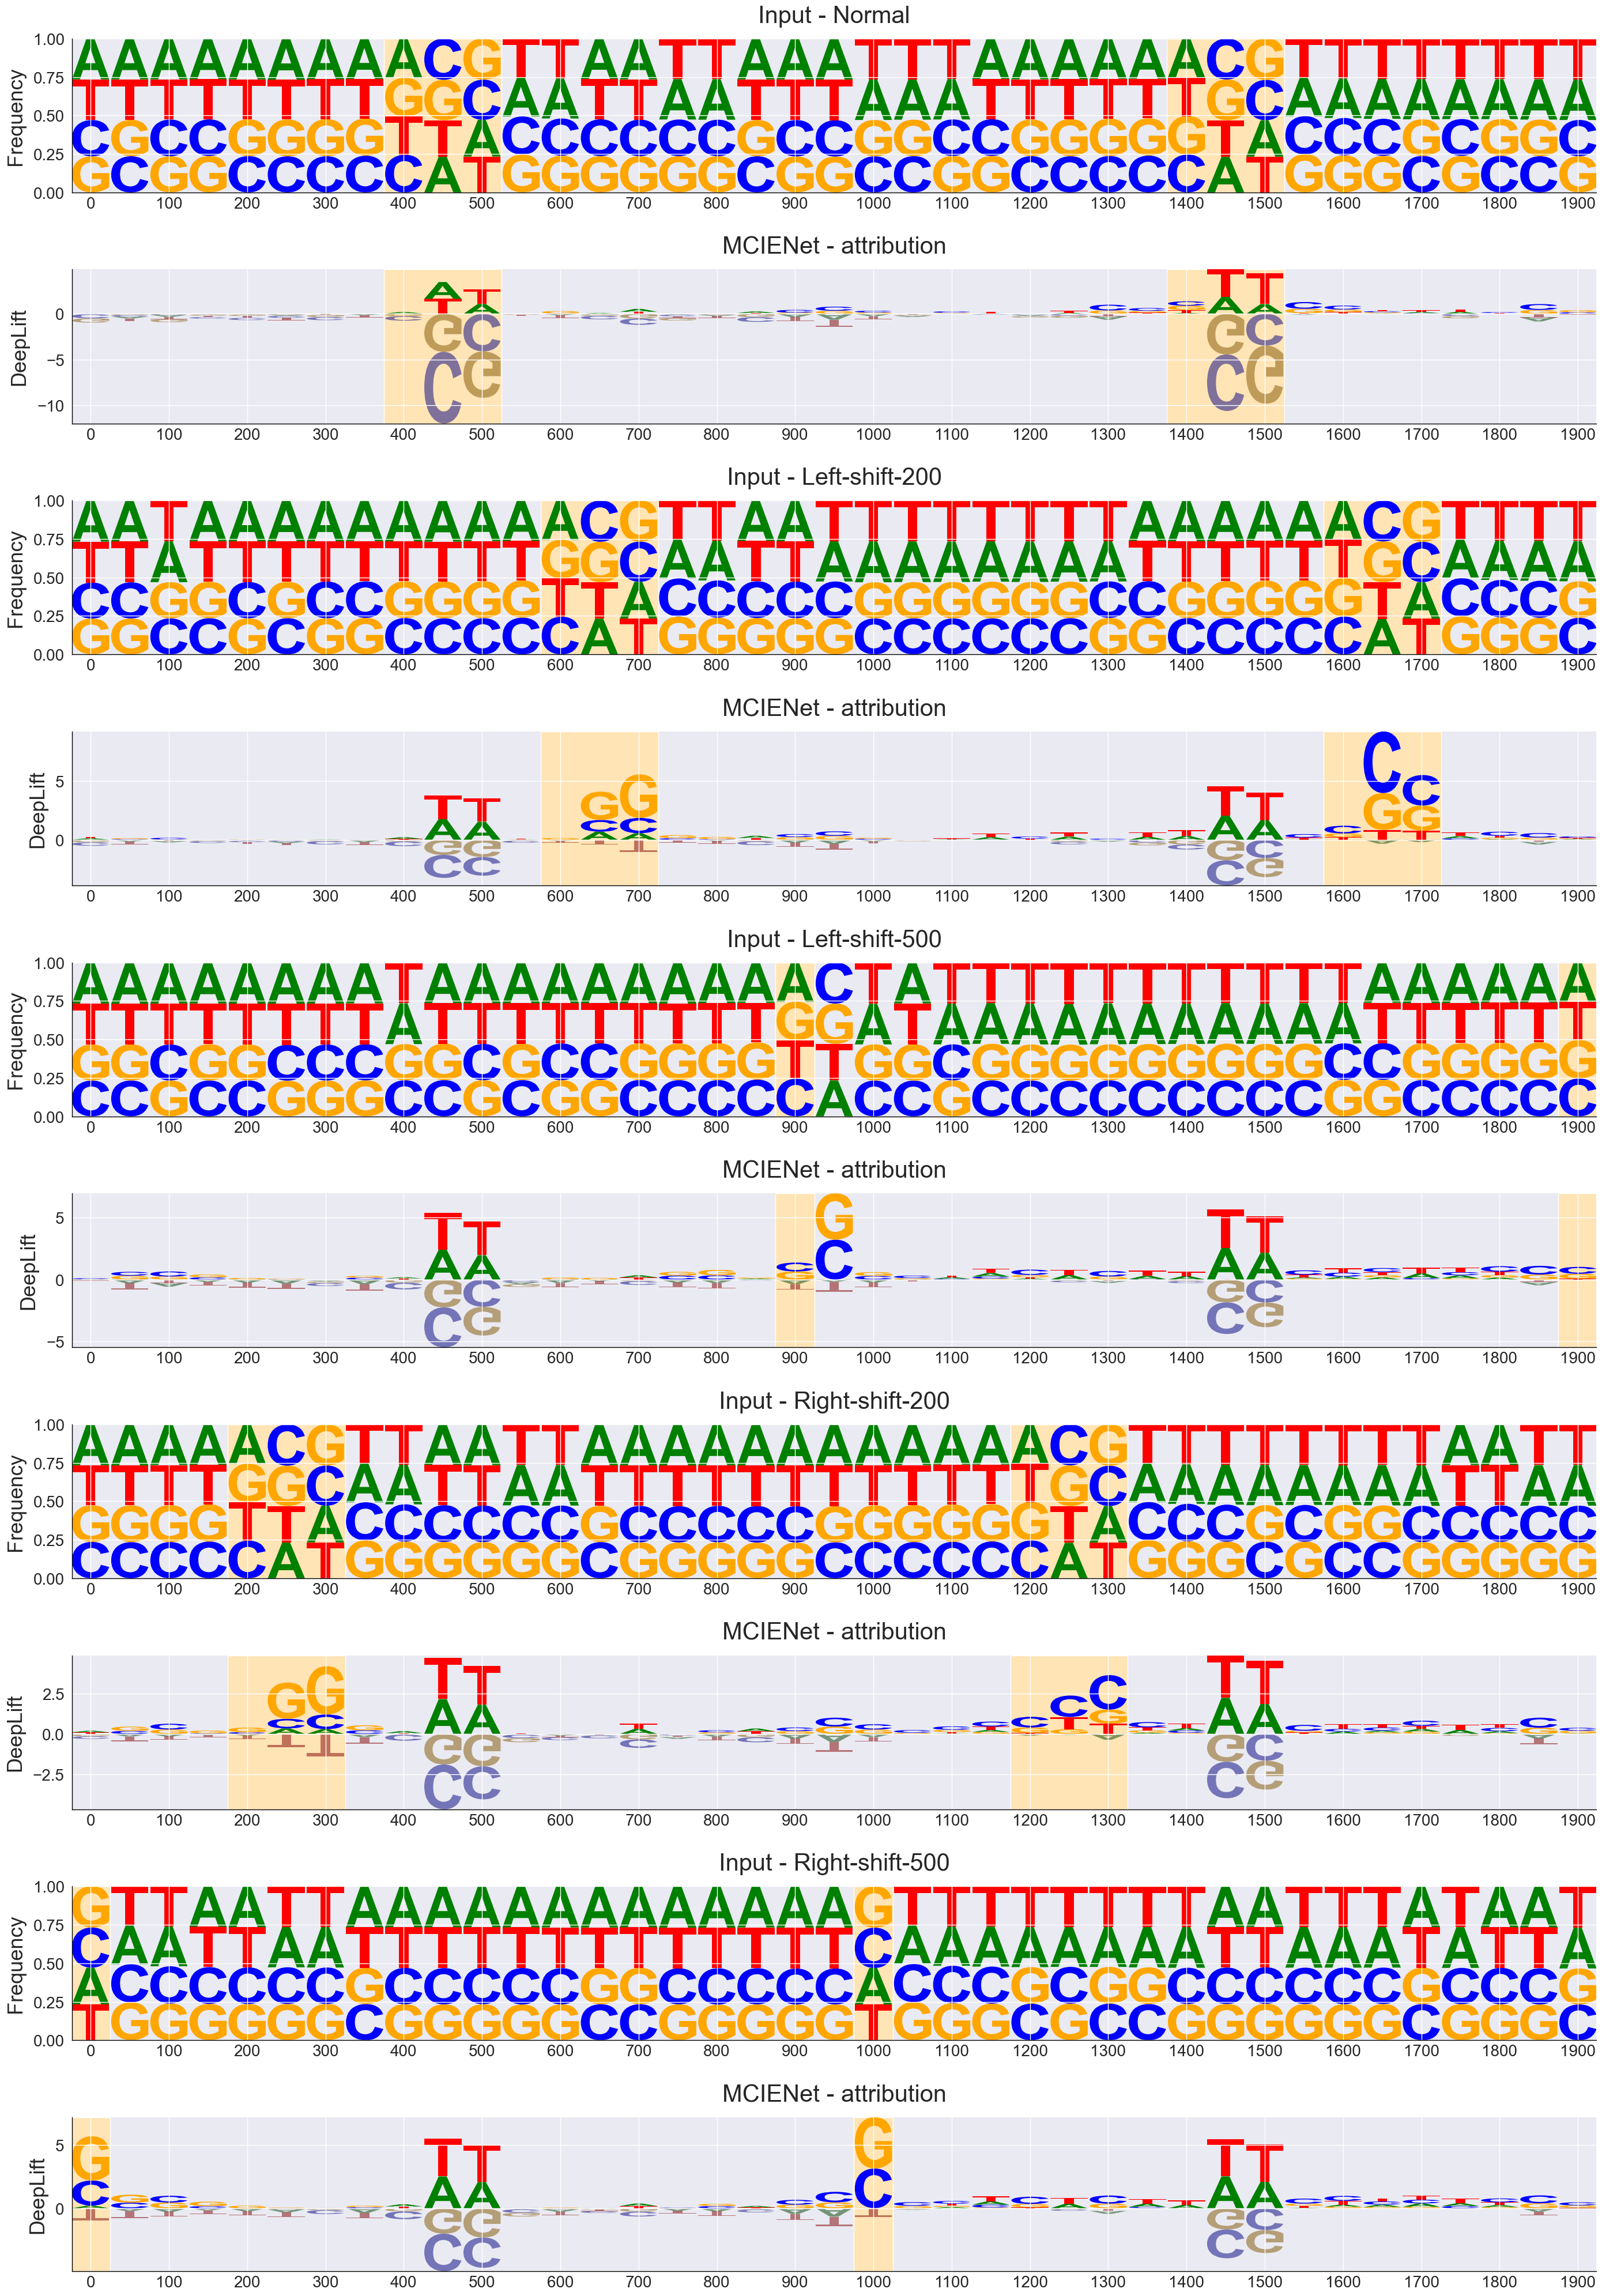

In [8]:
# 文字全局大小
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.rcParams['axes.labelsize'] = 26  # 設定 x 和 y 軸標籤字體大小
plt.rcParams['axes.titlesize'] = 30  # 設定圖標題字體大小

# 圖格局
col_num = 1
row_num = 10

bin_size = 50
window_step = 50

fig_pos, axes_pos = plt.subplots(nrows=row_num, ncols=col_num, figsize=(28, 4*row_num))  # 調整圖形大小
fig_neg, axes_neg = plt.subplots(nrows=row_num, ncols=col_num, figsize=(28, 4*row_num))  # 調整圖形大小

# 在每個 subplot 上繪圖 
curr_row = 0
for name, path in tar_files.items():
    print(name)

    # read file (BaseCNN & input) ==========================================
    with h5py.File(path) as f:
        input_all = np.array(f[tar_phase]['input'])
        attr_all = np.array(f[tar_phase]['attr'])
        label_all = np.array(f[tar_phase]['label'])

    # 取正負
    pos_idx, neg_idx = np.where(label_all==1)[0], np.where(label_all==0)[0]
    pos_num, neg_num = pos_idx.shape[0], neg_idx.shape[0]

    attr_pos = scale_and_normalize_batch(attr_all[pos_idx]).sum(0)
    attr_neg = scale_and_normalize_batch(attr_all[neg_idx]).sum(0)

    input_pos = input_all[pos_idx].sum(0) / pos_num
    input_neg = input_all[neg_idx].sum(0) / neg_num

    # 釋放記憶體
    del input_all; del attr_all ; del label_all; del pos_idx; del neg_idx

    # 處理偏移的標記 (位置轉換: 輸入 bp 長度 / bin_size)
    if name == 'Left-shift-200':
        mark_range = [[12,14], [32,34]]
    elif name == 'Right-shift-200':
        mark_range = [[4,6], [24,26]]
    elif name == 'Left-shift-500':
        mark_range = [[18,18], [38,38]]
    elif name == 'Right-shift-500':
        mark_range = [[0,0], [20,20]]
    else:
        mark_range = [[8,10], [28,30]]

    # plot =========================================================
    for sample in ['pos', 'neg']:
        if sample == 'pos':
            tar_ax = axes_pos[curr_row]
            tar_ax.set_title(f'Input - {name}', pad=20)
            plot_matrix(tar_ax, input_pos, bin_size, window_step, 
                        xlabel=None, ylabel='Frequency', 
                        mark_range=mark_range)

            tar_ax = axes_pos[curr_row+1]
            tar_ax.set_title('MCIENet - attribution', pad=20)
            plot_matrix(tar_ax, attr_pos, bin_size, window_step, 
                        xlabel=None, ylabel='DeepLift',
                        mark_range=mark_range)

        else:
            tar_ax = axes_neg[curr_row]
            tar_ax.set_title(f'Input - {name}', pad=20)
            plot_matrix(tar_ax, input_neg, bin_size, window_step, 
                        xlabel=None, ylabel='Frequency', 
                        mark_range=mark_range)

            tar_ax = axes_neg[curr_row+1]
            tar_ax.set_title('MCIENet - attribution', pad=20)
            plot_matrix(tar_ax, attr_neg, bin_size, window_step, 
                        xlabel=None, ylabel='DeepLift',
                        mark_range=mark_range)
    
    curr_row += 2 

fig_pos.tight_layout() # 自動調正版面
fig_pos.subplots_adjust(hspace=0.5) # 子圖之間的間距，越大越遠
fig_pos.savefig(os.path.join(output_folder, f'Anchor-shift-pos.png'))

fig_neg.tight_layout()
fig_neg.subplots_adjust(hspace=0.5) 
fig_neg.savefig(os.path.join(output_folder, f'Anchor-shift-neg.png'))

### Evaulation


In [56]:
import functools
from sklearn import metrics

def get_evaluation(pred, label, pred_prob):

    metrics_dt = {
        'Precision': metrics.precision_score,
        'Recall': metrics.recall_score,
        'Weighted_Precision': functools.partial(metrics.precision_score, average='weighted'),
        'Balanced_acc': metrics.balanced_accuracy_score,
        'F1': functools.partial(metrics.f1_score, average='binary'),
        'matthews_corrcoef': metrics.matthews_corrcoef
    }

    prob_metrics_dt = {
        'auPRCs': functools.partial(metrics.average_precision_score),
        'auROC': functools.partial(metrics.roc_auc_score)
    }

    result_dt = {k:v(y_true=label, y_pred=pred) for k, v in metrics_dt.items()}
    result_dt.update({k:v(y_true=label, y_score=pred_prob) for k, v in prob_metrics_dt.items()})

    report = metrics.classification_report(y_true=label, y_pred=pred, output_dict=True)

    return result_dt, report

In [62]:
result_ls = []
for name, path in tar_files.items():
    print(name)

    # read file (BaseCNN & input) ==========================================
    with h5py.File(path) as f:
        pred_all = np.array(f[tar_phase]['pred'])
        label_all = np.array(f[tar_phase]['label']).tolist()

    pred_ls = np.argmax(pred_all, axis=1).tolist()
    pred_prob_ls = [i[1] for i in pred_all]

    result_dt, _ = get_evaluation(pred_ls, label_all, pred_prob_ls)
    result_dt.update({'name': name})
    result_ls.append(result_dt)

Normal
Left-shift-200
Right-shift-200
Left-shift-500
Right-shift-500


In [66]:
df = pd.DataFrame(result_ls)

# 把 name 移到第一個
tar_col = df.pop('name')
df.insert(0, 'name', tar_col)

df.to_csv(os.path.join(output_folder, f'Anchor-shift-eval-result.csv'), index=False)
df

name  Precision    Recall  Weighted_Precision  Balanced_acc  \
0           Normal   0.709829  0.709395            0.903226      0.825704   
1   Left-shift-200   0.227077  0.751987            0.794350      0.620085   
2  Right-shift-200   0.291680  0.735888            0.818685      0.689276   
3   Left-shift-500   0.234041  0.593234            0.774567      0.602505   
4  Right-shift-500   0.230097  0.558386            0.768740      0.592396   

         F1  matthews_corrcoef    auPRCs     auROC  
0  0.709612           0.651567  0.776592  0.937497  
1  0.348821           0.179969  0.315974  0.676403  
2  0.417771           0.285780  0.479099  0.757489  
3  0.335659           0.154670  0.345906  0.645920  
4  0.325899           0.140316  0.345584  0.631785